# 目的
- エンゼルの出現確率を購入者毎に予測する
- 独立に予測するのと、階層モデルで予測するのを試す

In [1]:
import os, sys
import numpy as np
import pandas as pd
import scipy.stats as stats

import itertools
import math

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm

import ChocoUtils as cu

In [2]:
sns.set()

# データの取得

In [3]:
data = cu.get_data(db_file='../../data/choco-ball.db', filter_str="campaign is not 1 and taste is not 10")
data = data.drop(columns=['shop', 'factory'])

SELECT measure_date, best_before, prd_number, weight, box_weight, ball_number, factory, shop, angel, campaign, taste, buyer, (weight - box_weight), (weight - box_weight)/ball_number FROM measurement WHERE campaign is not 1 and taste is not 10;
Shape of MeasurementData(record_num, n_columns) : (290, 14)


In [4]:
# 銀のエンゼルのフラグデータ
data['silver'] = [1 if a == 1 else 0 for a in data['angel'].values]
# 金のエンゼル
data['gold'] = [1 if a == 2 else 0 for a in data['angel'].values]

# 購入者の調整
data['buyer'] = ['ピシャイ' if a in 'ピシャイ/佐藤' else a for a in data['buyer'].values]


In [5]:
data.head()

,measure_date,best_before,prd_number,weight,box_weight,ball_number,angel,campaign,taste,buyer,net_weight,mean_weight,silver,gold
0,2017-12-04,2018-02-01,BA6,34.513,4.710,16,0,2,0,根本,29.803,1.862688,0,0
1,2017-12-04,2018-02-01,AA6,33.644,4.731,16,0,2,0,根本,28.913,1.807062,0,0
2,2017-12-10,2018-09-01,CA9,31.103,4.776,15,0,2,1,時田,26.327,1.755133,0,0
3,2017-12-10,2018-09-01,CA9,31.477,4.767,15,0,2,1,時田,26.710,1.780667,0,0
4,2017-12-10,2018-09-01,CA9,31.615,4.777,15,0,2,1,時田,26.838,1.789200,0,0


In [6]:
# 購入者を限定する
data = data.query('buyer in ["ピシャイ", "西田", "時田"]')

grp = data.groupby(['buyer'])
print(grp.count()[['net_weight']])

       net_weight
buyer            
ピシャイ           80
時田            142
西田             59


# エンゼル出現確率の推定

## 購入者ごとに独立に推定

In [7]:
name_dict = {'ピシャイ':'pichai', '時田':'tokita', '西田':'nishida'}

In [8]:
buyer = data['buyer'].values
buyer_idx = pd.Categorical(data['buyer']).codes
buyer_cat = pd.Categorical(data['buyer']).categories
data['buyer_idx'] = buyer_idx
print(buyer_cat)
print(set(buyer_idx))

Index(['ピシャイ', '時田', '西田'], dtype='object')
{0, 1, 2}


In [9]:
total_counts = data.groupby(['buyer_idx']).count()['silver'].values
angel_counts = data.query('silver > 0').groupby(['buyer_idx']).count()['silver'].values

print('total_count : {}'.format(total_counts))
print('angel_count : {}'.format(angel_counts))


total_count : [ 80 142  59]
angel_count : [5 6 2]


max_theta : 0.05050505050505051


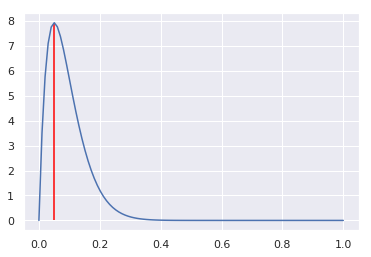

In [10]:
# 事前分布の形確認
(a, b) = (2.0, 20.0)

x = np.linspace(0, 1, 100)
y = stats.beta(a, b).pdf(x)
plt.plot(x, y)
plt.vlines(x=x[y.argmax()], ymin=0, ymax=max(y), colors='red')
print('max_theta : {}'.format(x[y.argmax()]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta]
100%|██████████| 5500/5500 [00:04<00:00, 1364.05it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122f07780>,
      dtype=object)

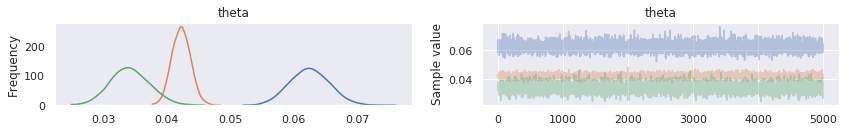

In [11]:
with pm.Model() as comparing_buyer_i:
    #theta = pm.Beta('theta', alpha=1, beta=1, shape=len(set(buyer_idx))) # 一様分布
    theta = pm.Beta('theta', alpha=2, beta=20, shape=len(set(buyer_idx)))
    
    angel = pm.Binomial('angel', n=total_counts[buyer_idx], p=theta[buyer_idx], observed=angel_counts[buyer_idx])
    
    trace = pm.sample(5000, chains=1)
pm.traceplot(trace)

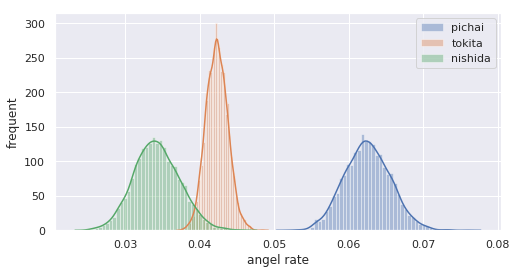

In [12]:
fig = plt.figure(figsize=(8, 4))
ax = fig.subplots(1, 1)

for i in np.arange(len(buyer_cat)):
    sns.distplot(trace['theta'][:,i], label=name_dict[buyer_cat[i]], ax=ax)
ax.legend()
ax.set_xlabel('angel rate')
ax.set_ylabel('frequent')
plt.savefig('buyer_effect.png')

## 購入者の性質を加える
- 真の出現率は決まっているはず(真の確率を$p$とする)
- 購入者毎の運の要素が入ってくる（不正行為かも、独自の購入戦略があるのかも）可能性がある
  - 購入者毎の特性を個人差$u_i$とする
- エンゼルの出現は確率$\theta_i$の二項分布
- 確率$\theta_i$は以下のロジットリンク関数で線形モデルを仮定
$$
logit(\theta_i) = p + u_i
$$

- $p$、$u_i$は正規分布を事前分布とする
  - 要検討

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [u, su, p]
Sampling 3 chains: 100%|██████████| 10500/10500 [00:06<00:00, 1524.08draws/s]
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 114 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7051770908024712, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123135668>,
      dtype=object)

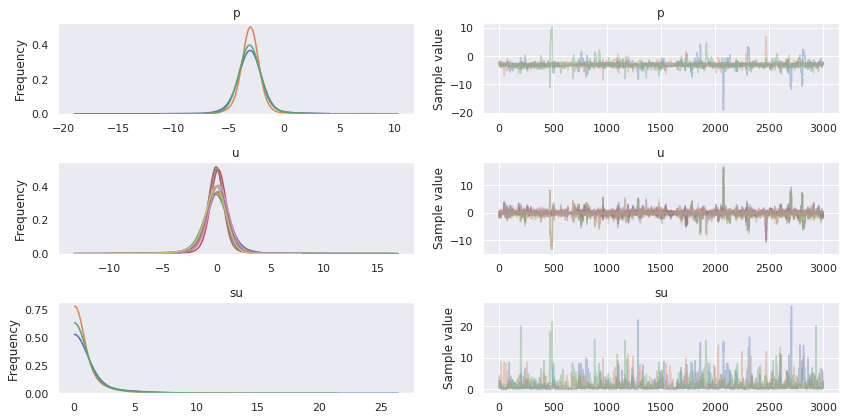

In [13]:
with pm.Model() as comparing_buyer_m:
    # 事前分布
    p = pm.Normal('p', mu=0, sd=10)
    
    su = pm.HalfNormal('su', sd=10)
    u = pm.Normal('u', mu=0, sd=su, shape=len(set(buyer_idx)))
    
    # 尤度
    angel = pm.Binomial('angel', n=total_counts, p=pm.invlogit(p+u), observed=angel_counts)
    
    # sample
    trace = pm.sample(3000, chains=3)
pm.traceplot(trace)

In [14]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p,-3.041367,1.202761,0.036037,-5.226476,-1.149863,798.930798,1.003055
u__0,0.115498,1.208439,0.035523,-1.886035,2.304719,830.865491,1.002948
u__1,-0.113508,1.204396,0.036271,-2.066663,2.034798,811.409682,1.003238
u__2,-0.245171,1.248389,0.036458,-2.431779,1.874762,844.321506,1.002839
su,1.196401,1.766345,0.060970,0.055136,4.309134,694.897076,1.000482


array([<matplotlib.axes._subplots.AxesSubplot object at 0x101b64080>,
      dtype=object)

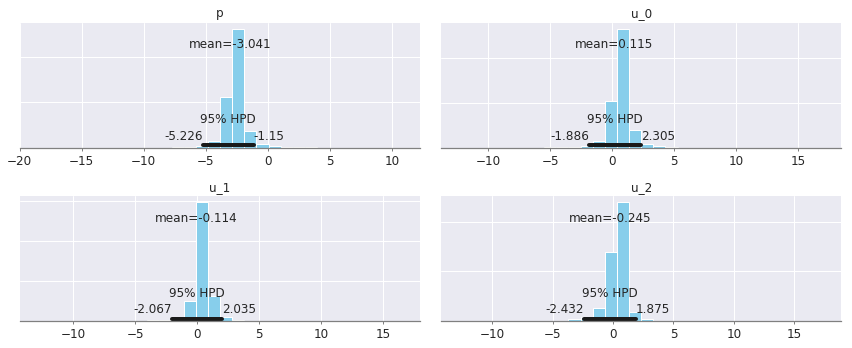

In [15]:
pm.plot_posterior(trace, varnames=['p', 'u'])

sigmoid関数を使ってみる。結局、logitは逆シグモイド関数になるんじゃなかったかな？だから、同じ結果になっているはず。

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [u, p, su]
Sampling 3 chains: 100%|██████████| 7500/7500 [00:04<00:00, 1545.02draws/s]
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 192 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6094533831164374, but should be close to 0.8. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122b6ebe0>,
      dtype=object)

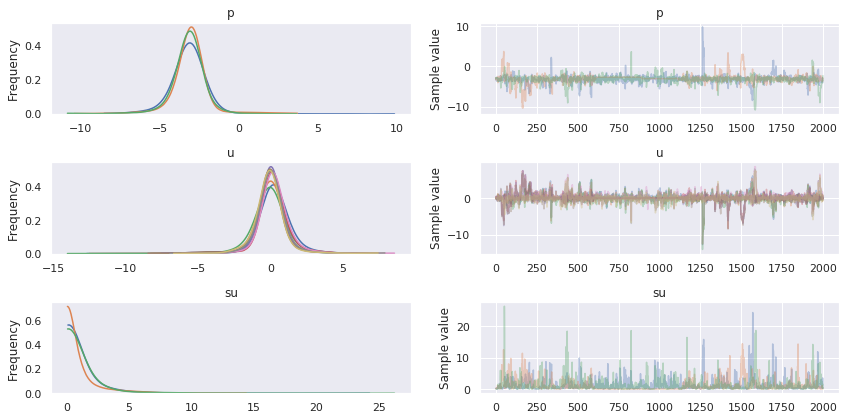

In [16]:
with pm.Model() as comparing_buyer_m2:
    su = pm.HalfNormal('su', sd=10)
    
    #p = pm.Beta('p', alpha=2, beta=20)
    p = pm.Normal('p', mu=0, sd=10)
    u = pm.Normal('u', mu=0, sd=su, shape=len(set(buyer_idx)))
    
    angel = pm.Binomial('angel', n=total_counts, p=pm.math.sigmoid(p+u), observed=angel_counts)
    
    trace = pm.sample(2000, chains=3)
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1242249b0>,
      dtype=object)

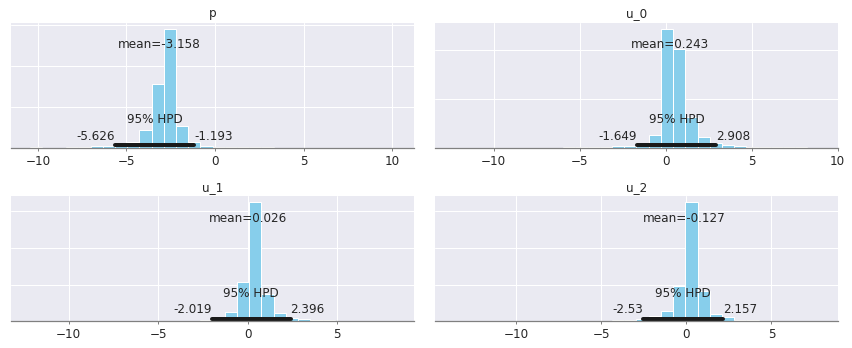

In [17]:
pm.plot_posterior(trace, varnames=['p', 'u'])

Text(0, 0.5, 'frequent')

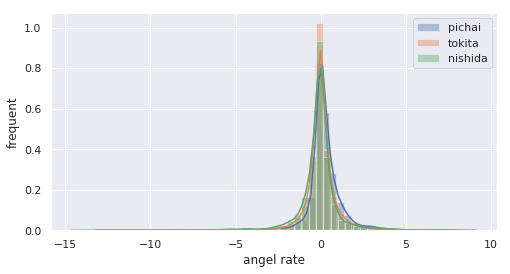

In [18]:
fig = plt.figure(figsize=(8, 4))
ax = fig.subplots(1, 1)

for i in np.arange(len(buyer_cat)):
    sns.distplot(trace['u'][:,i], label=name_dict[buyer_cat[i]], ax=ax)
ax.legend()
ax.set_xlabel('angel rate')
ax.set_ylabel('frequent')
#plt.savefig('buyer_effect.png')

In [19]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p,-3.158259,1.130712,0.052822,-5.626145,-1.192569,349.004239,1.001873
u__0,0.243247,1.144279,0.052713,-1.648796,2.907503,355.524530,1.001342
u__1,0.025925,1.120354,0.051237,-2.019275,2.395813,392.874833,1.000559
u__2,-0.126702,1.165255,0.050416,-2.529714,2.156570,438.151623,1.000434
su,1.205087,1.776945,0.074064,0.058923,4.303980,483.569002,1.001709


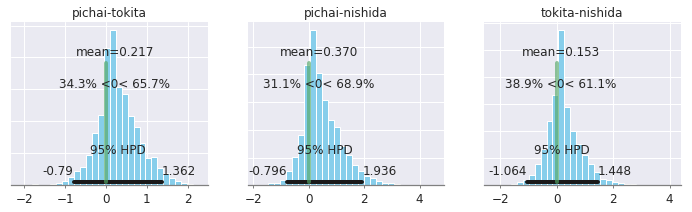

In [20]:
# 差の分布を確認
n_c = len(list(itertools.combinations(np.arange(0, 3), 2)))
n_col = 3
n_row = math.ceil(n_c/n_col)
fig = plt.figure(figsize=(12, 3*n_row))
ax = fig.subplots(n_row, n_col)
if n_row == 1:
    ax = ax[np.newaxis, :]

cnt=0
for (i,j) in itertools.combinations(np.arange(0, 3), 2):
    u_diff = trace['u'][:, i] - trace['u'][:, j]
    pm.plot_posterior(u_diff, ref_val=0, ax=ax[int(cnt/n_col), int(cnt%n_col)])
    ax[int(cnt/n_col), int(cnt%n_col)].set_title('{}-{}'.format(name_dict[buyer_cat[i]], name_dict[buyer_cat[j]]))
    cnt+=1

In [21]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

0.0035895050224109817 < 0.04076708118939006 < 0.23279978705246146


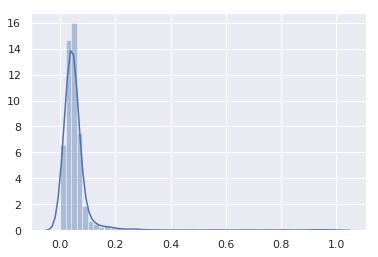

In [32]:
sns.distplot(sigmoid(trace['p']))
print('{} < {} < {}'.format(sigmoid(-5.626145), sigmoid(-3.158259), sigmoid(-1.192569)))